### Linear Regression of Airbnb Room Data

In [1]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np
from sklearn_pandas import DataFrameMapper
# import statsmodels.formula.api as smf
import pandas as pd

In [2]:
# Magics
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

In [3]:
def print_scores(model, xtrain, ytrain, xtest, ytest):
    """Prints scores for a model with training, and test data splits."""
    print('Train R2', round(model.score(xtrain, ytrain), 3))
    print('Test R2', round(model.score(xtest, ytest), 3))
    return None

In [4]:
def print_root_mean_err(true, pred):
    print('RMSError = ${}'.format(round(np.sqrt(mean_squared_error(true, pred)), 2)))
    return None

In [5]:
def delta(predictor, frame, field, new_val):
    """Predicts two values from a single row dataframe.
    Returns a tuple with the predicted price without changes,
    the predicted price with changes, and the difference."""
    test_vals = frame.copy()
    test_vals.loc[:, field] = new_val
    p_orig = predictor.predict(frame)
    p_new = predictor.predict(test_vals)
    return (p_orig, p_new, abs(p_orig - p_new))

In [6]:
# Read in room data
# rooms = pd.read_csv('../data/bogota-clean-10-06-2019--20-16-39.csv')
# rooms['cleaning_fee'] = replace_zeroes(rooms.cleaning_fee)
# rooms['beds'] = replace_zeroes(rooms.beds)

In [7]:
# Read in room data
rooms = pd.read_csv('../data/bogota_with_amenities.csv')

In [8]:
rooms.head()

,id,bathrooms,bedrooms,beds,cleaning_fee,is_superhost,lat,lng,person_capacity,picture_count,preview_amenity_names_Free parking,preview_amenity_names_Kitchen,preview_amenity_names_Washer,preview_amenity_names_Wifi,price_numeric,linear_distance
0,78672,1.5,1,1,15.0,1,4.672460,-74.056970,2,9,1,1,1,1,75.0,0.082535
1,241953,1.0,1,1,30.0,1,4.670883,-74.055893,3,34,1,1,1,1,49.0,0.081228
2,296620,1.0,1,1,25.0,1,4.695100,-74.040210,2,21,0,1,1,1,25.0,0.108791
3,320483,1.0,1,1,30.0,1,4.671075,-74.055489,3,33,1,1,1,1,44.0,0.081506
4,381143,2.0,3,3,17.0,0,4.617860,-74.350920,7,25,1,1,0,0,72.0,0.278051


In [9]:
# sns.pairplot(rooms.drop('id', axis=1), diag_kind='kde')

In [10]:
# Set target variable and features array. The target is the price of the room.
y = rooms.price_numeric
X = rooms[['bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'is_superhost',
       'person_capacity', 'picture_count',
       'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
       'preview_amenity_names_Washer', 'preview_amenity_names_Wifi', 'linear_distance']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [11]:
X.shape

(1452, 12)

In [12]:
# View price range
(rooms.price_numeric.min(), rooms.price_numeric.max())

(10.0, 130.0)

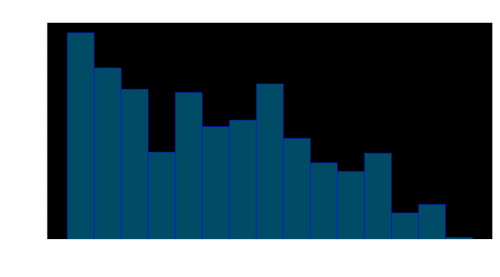

In [13]:
# Create a histogram of prices
plt.figure(figsize=(8,4))
plt.style.use('dark_background')
sns.distplot(rooms.price_numeric, kde=False, hist_kws=dict(color='deepskyblue', edgecolor="blue", linewidth=1))
plt.xlabel('Price USD, Range: \$10 - \$130');
plt.ylabel('Count');
plt.title('Histogram of Prices in USD');
plt.savefig('../images/prices_hist.svg')                                           

In [14]:
# Statsmodels ordinary least squares fit of the data. Adding constant since statsmodels doesn't
# do that by default.
Xc = sm.add_constant(X)
model = sm.OLS(y, Xc)
fit = model.fit()
fit.summary()

/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_numeric   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     81.40
Date:                Thu, 10 Oct 2019   Prob (F-statistic):          2.29e-152
Time:                        21:46:18   Log-Likelihood:                -6608.1
No. Observations:                1452   AIC:                         1.324e+04
Df Residuals:                    1439   BIC:                         1.331e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 21.2840      4.850      4.389      0.000      11.771      30.797
bathrooms                              7.1665      1.181      6.069      0.000       4.850       9.483
bedrooms                               3.5669      1.153      3.094      0.002       1.305       5.828
beds                                   0.8585      0.611      1.406      0.160      -0.340       2.057
cleaning_fee                           0.2907      0.049      5.980      0.000       0.195       0.386
is_superhost                          -6.3123      1.362     -4.635      0.000      -8.984      -3.641
person_capacity                        1.1933      0.548      2.178      0.030       0.118       2.268
picture_count                         -0.1308      0.046     -2.836      0.005      -0.221      -0.040
preview_amenity_names_Free parking    18.6430      1.374     13.565      0.000      15.947      21.339
preview_amenity_names_Kitchen         -6.8806      3.444     -1.998      0.046     -13.636      -0.125
preview_amenity_names_Washer          -0.7403      1.473     -0.503      0.615      -3.629       2.149
preview_amenity_names_Wifi             1.1316      2.971      0.381      0.703      -4.697       6.960
linear_distance                       40.7782      9.847      4.141      0.000      21.462      60.095
==============================================================================
Omnibus:                       55.453   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.333
Skew:                           0.503   Prob(JB):                     4.81e-14
Kurtosis:                       2.968   Cond. No.                         472.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

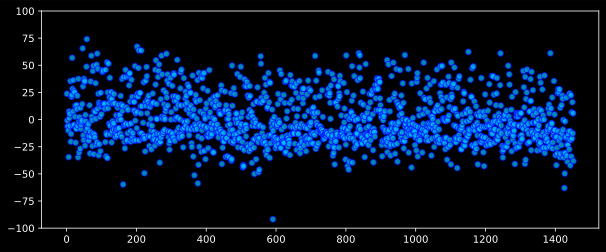

In [15]:
# Plot residuals
plt.figure(figsize=(10,4))
plt.style.use('dark_background')
plt.ylim((-100, 100)) 
plt.scatter(np.arange(1, len(y)+1, 1), fit.resid, color='deepskyblue', edgecolor='blue', alpha=0.7);
plt.savefig('../images/initial_residuals.svg');

In [16]:
# Run an sklearn linear regression on unsplit data to verify the same result as statsmodels
lr_unsplit = LinearRegression()
lr_unsplit.fit(X, y)
print(lr_unsplit.score(X, y))
print(r2_score(y, lr_unsplit.predict(X)))

0.4043501882637539
0.4043501882637539


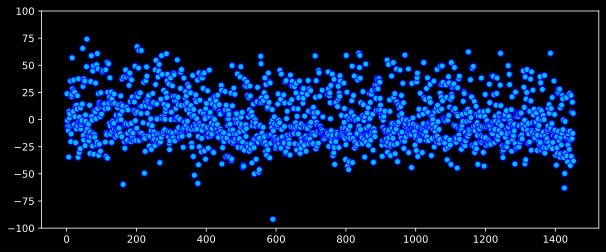

In [17]:
# Plot residuals for sklearn
plt.figure(figsize=(10,4))
plt.ylim((-100, 100)) 
plt.scatter(np.arange(1, len(y) + 1), y - lr_unsplit.predict(X), color='deepskyblue', edgecolor='blue');

In [18]:
# Fit training data and attempt to predict test data.
lr = LinearRegression(n_jobs=10)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

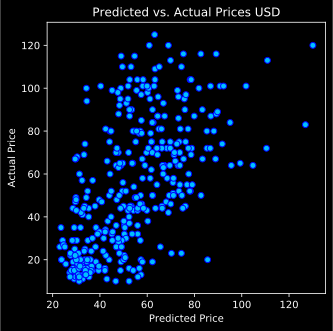

In [19]:
# Plot predicted values vs. actual values.
plt.figure(figsize=(5,5))
plt.style.use('dark_background')
plt.title('Predicted vs. Actual Prices USD')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y_predict, y_test, color='deepskyblue', edgecolor='blue');
plt.savefig('../images/initial_predict_v_actual.svg')

Residuals are y_test - y_predict

Display the $R^2\; score$ for the predicted values.

In [20]:
# r^2 scores
print_scores(lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, y_predict)

Train R2 0.418
Test R2 0.357
RMSError = $24.39


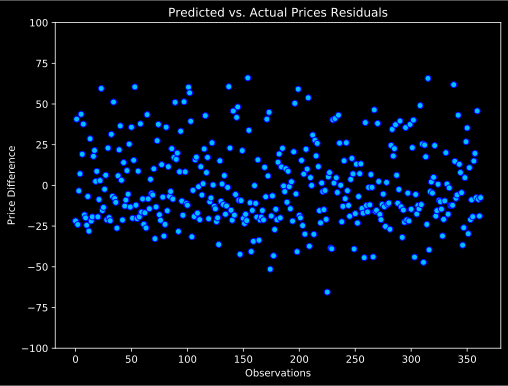

In [21]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.figure(figsize=(8,6))
plt.style.use('dark_background')
plt.scatter(x_vals, y_test - y_predict, color='deepskyblue', edgecolor='blue')
plt.ylim(-100, 100)
plt.title('Predicted vs. Actual Prices Residuals')
plt.xlabel('Observations')
plt.ylabel('Price Difference');

#### Since Linear Regression didn't perform that great we will try applying some transforms

In [22]:
# Rerun the regression with transforms
pipe = make_pipeline(StandardScaler(), LinearRegression(copy_X=True))
pipe.fit(X_train, y_train)
y_scaled_predict = pipe.predict(X_test)
# pipe.fit_transform()

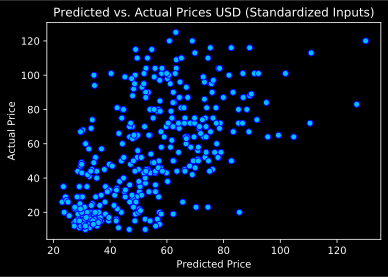

In [23]:
# Plot predicted values vs. actual values.
plt.style.use('dark_background')
plt.title('Predicted vs. Actual Prices USD (Standardized Inputs)')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y_scaled_predict, y_test, color='deepskyblue', edgecolor='blue');
plt.savefig('../images/predicted_v_actual_with_standardization.svg')

In [24]:
# Print test scores for standardized inputs
print_scores(pipe, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, y_scaled_predict)

Train R2 0.418
Test R2 0.357
RMSError = $24.39


#### Standardization didn't have a noticable effect.

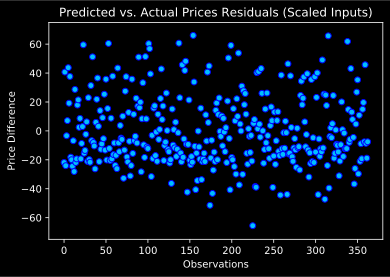

In [25]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.style.use('dark_background')
plt.scatter(x_vals, y_test - y_scaled_predict, color='deepskyblue', edgecolor='blue')
plt.ylim(-75, 75)
plt.title('Predicted vs. Actual Prices Residuals (Scaled Inputs)')
plt.xlabel('Observations')
plt.ylabel('Price Difference');

#### Try taking the log of some features to see if that improves performance of the model. Need to improve upon $RMSError = \$24.39$

In [26]:
# Build a DataFrameMapper object to transform some features and pass it to a pipe line.
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler())
maptf = DataFrameMapper([
    (['bedrooms', 'beds'], log_and_std),
    (['bathrooms', 'cleaning_fee', 'picture_count',
       'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
       'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
       'linear_distance'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.405
Test R2 0.347
RMSError = $24.57


#### Scaling inputs didn't make much difference. Trying adding Polynomial Effects

In [27]:
# Build a DataFrameMapper object to transform some features and pass it to a pipe line.
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler(), PolynomialFeatures(3))
maptf = DataFrameMapper([
    (['bedrooms', 'beds'], log_and_std),
    (['bathrooms', 'cleaning_fee', 'picture_count',
       'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
       'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
       'linear_distance'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression())
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.416
Test R2 0.362
RMSError = $24.28


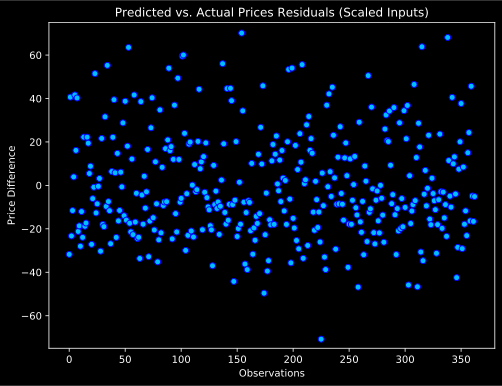

In [28]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.figure(figsize=(8,6))
plt.style.use('dark_background')
plt.scatter(x_vals, y_test - mapped_lr.predict(X_test), color='deepskyblue', edgecolor='blue')
plt.ylim(-75, 75)
plt.title('Predicted vs. Actual Prices Residuals (Scaled Inputs)')
plt.xlabel('Observations')
plt.ylabel('Price Difference');
plt.savefig('../images/final_residuals.svg')

#### The next step adds PloynomialFeatures to all features. This reduced the $R^2$ to negative numbers, and increase the room mean squared error.

In [29]:
# Test adding PolynomialFeatures to all features.
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler(), PolynomialFeatures(3))
std_and_pf = make_pipeline(StandardScaler(), PolynomialFeatures())
maptf = DataFrameMapper([
    (['bedrooms', 'beds'], log_and_std),
    (['bathrooms', 'cleaning_fee', 'picture_count',
       'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
       'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
       'linear_distance'], std_and_pf)
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.485
Test R2 -0.029
RMSError = $30.84


#### Attempting some regularization.

In [30]:
# Base Lasso 
ls = LassoCV(cv=5, copy_X=True)
ls.fit(X_train, y_train)
ls_y_predict = ls.predict(X_test)
print_scores(ls, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, ls_y_predict)

Train R2 0.417
Test R2 0.354
RMSError = $24.44


In [31]:
# Pass the features through the same transforms as those that got my top results before.
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler(), PolynomialFeatures(3))
maptf = DataFrameMapper([
    (['bedrooms', 'beds'], log_and_std),
    (['bathrooms', 'cleaning_fee', 'picture_count',
       'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
       'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
       'linear_distance'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, Lasso(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.402
Test R2 0.342
RMSError = $24.65


#### These values are high in RMSE. Running them through a loop to see how changing alphas behaves.

In [32]:
# Run the Lasso in a loop with different alphas to see how they r2 responds
test_alphas = np.arange(0.25, 10, 0.25)
r_squares_train = []
r_squares_test = []
r_diffs = []
for idx, val in enumerate(test_alphas):
    log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler(), PolynomialFeatures(3))
    maptf = DataFrameMapper([
        (['bedrooms', 'beds'], log_and_std),
        (['bathrooms', 'cleaning_fee', 'picture_count',
           'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
           'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
           'linear_distance'], StandardScaler())
    ])
    mapped_lr = make_pipeline(maptf, Lasso(alpha=val, copy_X=True))
    mapped_lr.fit(X_train, y_train)
    r_squares_train.append(mapped_lr.score(X_train, y_train))
    r_squares_test.append(mapped_lr.score(X_test, y_test))
    r_diffs.append(r_squares_train[idx] - r_squares_test[idx])
min_alpha = test_alphas[np.argmin(np.abs(r_diffs))]

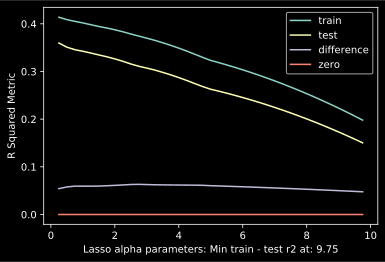

In [33]:
# Plot the differences in R2
plt.plot(test_alphas, r_squares_train)
plt.plot(test_alphas, r_squares_test)
plt.plot(test_alphas, r_diffs)
plt.plot(test_alphas, np.zeros(len(test_alphas)))
plt.legend(['train', 'test', 'difference', 'zero'])
plt.ylabel('R Squared Metric')
plt.xlabel('Lasso alpha parameters: Min train - test r2 at: {}'.format(min_alpha));

#### Lasso with alphas did not converge. Trying with Ridge regression.

In [34]:
# Run the Ridge in a loop with different alphas to see how they r2 responds
test_alphas = np.arange(900, 1500, 10)
r_squares_train = []
r_squares_test = []
r_diffs = []
for idx, val in enumerate(test_alphas):
    log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler(), PolynomialFeatures(3))
    maptf = DataFrameMapper([
        (['bedrooms', 'beds'], log_and_std),
        (['bathrooms', 'cleaning_fee', 'picture_count',
           'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
           'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
           'linear_distance'], StandardScaler())
    ])
    mapped_lr = make_pipeline(maptf, Ridge(alpha=val, copy_X=True))
    mapped_lr.fit(X_train, y_train)
    r_squares_train.append(mapped_lr.score(X_train, y_train))
    r_squares_test.append(mapped_lr.score(X_test, y_test))
    r_diffs.append(r_squares_train[idx] - r_squares_test[idx])
min_alpha = test_alphas[np.argmin(np.abs(r_diffs))]

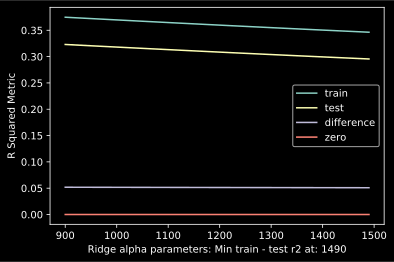

In [35]:
# Plot the difference in R2 across different alphas
plt.plot(test_alphas, r_squares_train)
plt.plot(test_alphas, r_squares_test)
plt.plot(test_alphas, r_diffs)
plt.plot(test_alphas, np.zeros(len(test_alphas)))
plt.legend(['train', 'test', 'difference', 'zero'])
plt.ylabel('R Squared Metric')
plt.xlabel('Ridge alpha parameters: Min train - test r2 at: {}'.format(min_alpha));

In [36]:
test_alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
r_squares_train = []
r_squares_test = []
r_diffs = []
for idx, val in enumerate(test_alphas):
    ls_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), 
                            Ridge(copy_X=True, max_iter=1000, alpha=val, random_state=42))
    ls_pipe.fit(X_train, y_train)
    ls_pipe_y_predicted = ls.predict(X_test)
    r_squares_train.append(ls_pipe.score(X_train, y_train))
    r_squares_test.append(ls_pipe.score(X_test, y_test))
    r_diffs.append(r_squares_train[idx] - r_squares_test[idx])
min_alpha = test_alphas[np.argmin(np.abs(r_diffs))]

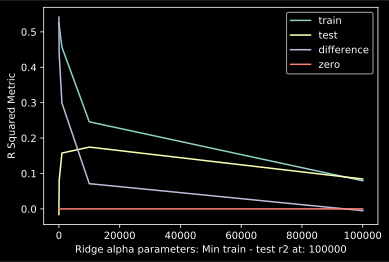

In [37]:
# Plot the difference in R2 across different alphas
plt.plot(test_alphas, r_squares_train)
plt.plot(test_alphas, r_squares_test)
plt.plot(test_alphas, r_diffs)
plt.plot(test_alphas, np.zeros(len(test_alphas)))
plt.legend(['train', 'test', 'difference', 'zero'])
plt.ylabel('R Squared Metric')
plt.xlabel('Ridge alpha parameters: Min train - test r2 at: {}'.format(min_alpha));

#### Using the best model found, test new values to see how those values impact the predicted price.

In [38]:
log_and_std = make_pipeline(FunctionTransformer(np.log1p, validate=True), StandardScaler(), PolynomialFeatures(3))
maptf = DataFrameMapper([
    (['bedrooms', 'beds'], log_and_std),
    (['bathrooms', 'cleaning_fee', 'picture_count',
       'preview_amenity_names_Free parking', 'preview_amenity_names_Kitchen',
       'preview_amenity_names_Washer', 'preview_amenity_names_Wifi',
       'linear_distance'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression())
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.416
Test R2 0.362
RMSError = $24.28


In [56]:
X_test.sample(1)

,bathrooms,bedrooms,beds,cleaning_fee,is_superhost,person_capacity,picture_count,preview_amenity_names_Free parking,preview_amenity_names_Kitchen,preview_amenity_names_Washer,preview_amenity_names_Wifi,linear_distance
198,1.5,1,1,14.0,1,2,17,1,1,1,1,0.109406


In [40]:
# Price difference for one less bedroom
delta(mapped_lr, X_test.loc[192:192], 'bedrooms', 1)

(array([69.25283099]), array([61.00679995]), array([8.24603104]))

In [41]:
# Price difference for adding one room
delta(mapped_lr, X_test.loc[192:192], 'bedrooms', 3)

(array([69.25283099]), array([80.30849969]), array([11.0556687]))

In [63]:
# Price difference for adding one room
delta(mapped_lr, X_test.loc[198:198], 'bedrooms', 2)

(array([53.4494887]), array([66.15992292]), array([12.71043422]))

In [60]:
# Price difference for adding one room
delta(mapped_lr, X_test.loc[198:198], 'bedrooms', 0)

(array([53.4494887]), array([51.32151194]), array([2.12797676]))

In [42]:
# Price difference for adding one bed
delta(mapped_lr, X_test.loc[192:192], 'beds', 4)

(array([69.25283099]), array([72.08192194]), array([2.82909095]))

In [43]:
# The model predicts zero change in price based on the number of guests
delta(mapped_lr, X_test.loc[192:192], 'person_capacity', 100)

(array([69.25283099]), array([69.25283099]), array([0.]))

In [44]:
# Price difference for one less bath room
delta(mapped_lr, X_test.loc[192:192], 'bathrooms', 1)

(array([69.25283099]), array([61.24055963]), array([8.01227136]))

In [66]:
# Price difference for one less bath room
delta(mapped_lr, X_test.loc[198:198], 'bathrooms', 3.5)

(array([53.4494887]), array([69.47403141]), array([16.02454271]))

In [45]:
# Price difference for no cleaning fee
delta(mapped_lr, X_test.loc[192:192], 'cleaning_fee', 0)

(array([69.25283099]), array([63.00638821]), array([6.24644278]))

In [46]:
# Price difference for non-superhosts is zero
delta(mapped_lr, X_test.loc[192:192], 'is_superhost', 0)

(array([69.25283099]), array([69.25283099]), array([0.]))

In [47]:
# Price difference for less pictures
delta(mapped_lr, X_test.loc[192:192], 'picture_count', 7)

(array([69.25283099]), array([70.16229252]), array([0.90946153]))

In [48]:
# Price difference for free parking
delta(mapped_lr, X_test.loc[192:192], 'preview_amenity_names_Free parking', 0)

(array([69.25283099]), array([52.49967125]), array([16.75315974]))

In [49]:
# Price difference no kitchen
delta(mapped_lr, X_test.loc[192:192], 'preview_amenity_names_Kitchen', 0)

(array([69.25283099]), array([72.81526769]), array([3.5624367]))

In [50]:
# Price difference no WIFI
delta(mapped_lr, X_test.loc[192:192], 'preview_amenity_names_Wifi', 0)

(array([69.25283099]), array([69.65180582]), array([0.39897483]))

In [51]:
# Price difference for a 10x increase in linear distance from the historic center
delta(mapped_lr, X_test.loc[192:192], 'linear_distance', 0.064312 * 10)

(array([69.25283099]), array([91.78572875]), array([22.53289776]))

In [54]:
# Price difference for a 10x increase in linear distance from the historic center
delta(mapped_lr, X_test.loc[192:192], 'linear_distance', 0.0023887913261808084)

(array([69.25283099]), array([66.84215299]), array([2.410678]))

In [55]:
# Price difference for a 10x increase in linear distance from the historic center
delta(mapped_lr, X_test.loc[192:192], 'linear_distance', 0.4629644153290826)

(array([69.25283099]), array([84.7722972]), array([15.51946621]))

In [52]:
X_train.linear_distance.max()

0.4629644153290826

In [53]:
X_train.linear_distance.min()

0.0023887913261808084